In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seaborn as sns

In [2]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'
iters = [xx for xx in range(10,1440*2+10,10)]
levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [3]:
depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_nob,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# centers mask bathy with bay
depth_bay = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)

# 
zz = 37

In [4]:
def get_snapshot_ssh(ds,tt,fld='ETAN'):
    W = ds[fld][tt,:,:]
    return(W)
def get_snapshot_w(ds,tt,zz,fld='ETAN'):
    W = ds[fld][tt,zz,:,:]
    return(W)

def plot_field_w(ax,tt,lon,lat,eta,time,mask,zind,
                 cmap=cmo.cm.rain,vmin=-0.3, vmax=0.3, title='SSH Bay-No Bay ', cbar='right'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(lon,lat, 
                       np.ma.masked_array(eta,mask=mask[zind,:,:]),
                       cmap=cmap, vmin=vmin, vmax=vmax)    
    
    if cbar =='right':
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar_ax = fig.add_axes([0.88, 0.125, 0.022, 0.755]) 
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                          cax=cbar_ax, orientation='vertical', 
                           format='%1.1f',label='SSH (mm)', extend='both')
    
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar_ax = fig.add_axes([0.485, 0.125, 0.022, 0.755]) 
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                          cax=cbar_ax, orientation='vertical', 
                           format='%1.1f', extend='both')
    
    ax.set_title('%s t=%1.1f h'%(title,time[tt]/3600))
    ax.set_aspect(1)
    return(ax)

def plot_field_p(ax,tt,lon,lat,eta,time,mask,zind,
                 cmap=cmo.cm.balance,vmin=-3, vmax=3, title='w Bay-No Bay', cbar='right'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(lon,lat, 
                       np.ma.masked_array(eta*1E5,mask=mask[zind,:,:]),
                       cmap=cmap, vmin=vmin, vmax=vmax)    
    
    if cbar =='right':
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar_ax = fig.add_axes([0.883, 0.125, 0.022, 0.755]) 
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                          cax=cbar_ax, orientation='vertical', 
                           format='%1.1f',label='w ($10^{-5}$ m s$^{-1}$)', extend='both')
    
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar_ax = fig.add_axes([0.46, 0.125, 0.022, 0.755]) 
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                          cax=cbar_ax, orientation='vertical', 
                           format='%1.1f',label='w ($10^{-5}$ m s$^{-1}$)', extend='both')
    
    ax.set_title('%s at %1.1f m, t=%1.1f h'%(title, Zl[zz], time[tt]/3600))
    ax.set_aspect(1)
    return(ax)

def init():
    tt=0
    Wbay1 = get_snapshot_ssh(ds, tt,  'ETAN')
    Wnb1 = get_snapshot_ssh(ds2, tt,  'ETAN')
    
    Wbay2 = get_snapshot_w(ds, tt,zz,  'WVEL')
    Wnb2 = get_snapshot_w(ds2, tt,zz,  'WVEL')
    
    axx= plot_field_p(ax1,tt,lon,lat,(Wbay2-Wnb2),time,
                      mask,zz,cmap=cmo.cm.balance, vmin=-3, vmax=3, title='Bay-No bay', cbar='left')
    axx.contour(lon, lat, depth_bay, levels=[0, 250, 500],
                colors=['k','0.5','0.8'], alpha=0.3)
  
    
    axxx = plot_field_w(ax2,tt,lon,lat,(Wbay1-Wnb1)*1000,time,
                        mask,0,cmap=cmap, vmin=-1, vmax=1, title='Bay-No Bay', cbar='right')
  
    axxx.contour(lon, lat, depth_bay, levels=[0, 250, 500],
                 colors=['k','0.5','0.8'], alpha=0.3)
  
    ax1.set_xlabel('lon')
    ax1.set_ylabel('lat')
    ax2.set_xlabel('lon')
    ax1.set_xlim(238-360, -114)
    ax1.set_ylim(27.0,35.3)
    ax2.set_xlim(238-360, -114)
    ax2.set_ylim(27.0,35.3)
    ax2.set_yticks([])

def animate(t):
    tt = (2*t) #3*t
    print(tt)
    Wbay1 = get_snapshot_ssh(ds, tt,  'ETAN')
    Wnb1 = get_snapshot_ssh(ds2, tt,  'ETAN')
    
    Wbay2 = get_snapshot_w(ds, tt,zz,  'WVEL')
    Wnb2 = get_snapshot_w(ds2, tt,zz,  'WVEL')
     
    axx= plot_field_p(ax1,tt,lon,lat,(Wbay2-Wnb2),time,
                      mask,zz,cmap=cmo.cm.balance, vmin=-2.5, vmax=2.5, title='SSH Bay-No bay', cbar='left')
    axxx = plot_field_w(ax2,tt,lon,lat,(Wbay1-Wnb1)*1000,time,
                        mask,0,cmap=cmap, vmin=-1, vmax=1, title='Bay-No Bay', cbar='right')
    ax1.set_xlabel('lon')
    ax1.set_ylabel('lat')
    ax2.set_xlabel('lon')
    ax1.set_xlim(238-360, -114)
    ax1.set_ylim(27.0,35.3)
    ax2.set_xlim(238-360, -114)
    ax2.set_ylim(27.0,35.3)
    ax2.set_yticks([])

In [5]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286


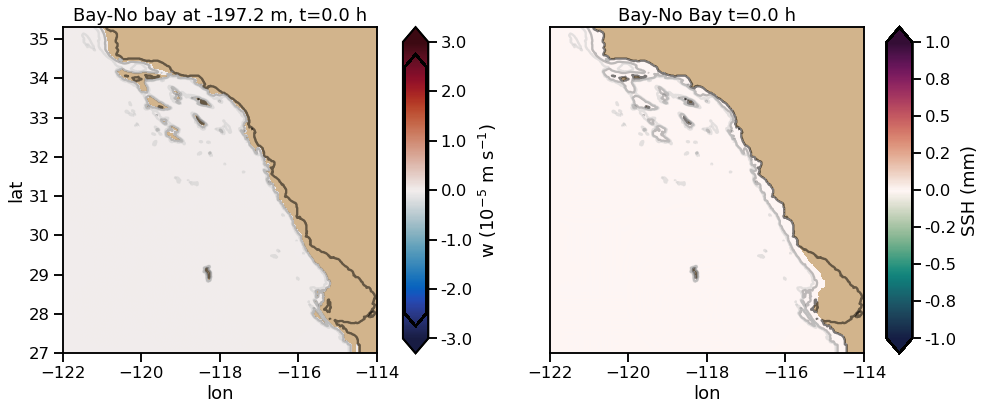

In [6]:
sns.set_context('talk')
cmap=cmo.cm.curl
fig = plt.figure(figsize=(16,6))
gs = GridSpec(1,2, width_ratios=[1,1], wspace=0.2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Uncomment lines below to run and save animation
anim = animation.FuncAnimation(fig, animate, init_func=init, blit=False,
                               frames=144, repeat=False)
anim.save('w_ssh_febTS.mov', writer=writer, dpi=500)